<a href="https://colab.research.google.com/github/gabriel-gatti/air_pollution_forecast/blob/master/Analise_dos_restulados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

###Import libraries and data

In [264]:
import pandas as pd
import datetime
from copy import deepcopy
from sklearn.linear_model import LinearRegression
import matplotlib
import seaborn as sns
sns.set_theme(style="whitegrid")
get_palette = lambda x: sns.cubehelix_palette(light=.8, n_colors=x)

uri = 'https://raw.githubusercontent.com/gabriel-gatti/air_pollution_forecast/master/Resultados_TCC.csv'
df_raw = pd.read_csv(uri)

###Tratamento do DataFrame

In [53]:
num_cols = ['Time to Select (seconds)', 'RMSE', 'drop_out', 'learning_rate']

for col in num_cols:
  df_raw[col] = df_raw[col].apply(lambda x: float(x.replace(',','.')))

df_numeric = df_raw

In [54]:
attrs = ['PRESS', 'RH_DP', 'TEMP', 'WIND', 'CO', 'NO2', 'OZONE', 'SO2']

for attr in attrs:
  df_numeric[attr] = df_numeric['Attributes Selected'].apply(lambda x: 1 if attr in x else 0)

df_encoded = df_numeric.drop('Attributes Selected', axis=1)

In [55]:
get_time = lambda x: datetime.datetime.strptime(x, '%H:%M:%S.%f')
base = get_time('00:00:00.000000')

df_encoded['Training Duration'] = df_encoded['Training Duration'].apply(lambda x: (get_time(x) - base).total_seconds())

df_final = df_encoded

# Análise dos Attributos

###Copiando Dataset para evitar overwrite

In [92]:
erro_col = ['RMSE']
df_fs = deepcopy(df_final[attrs + erro_col])

df_fs

,PRESS,RH_DP,TEMP,WIND,CO,NO2,OZONE,SO2,RMSE
0,0,1,1,0,0,0,1,0,0.374676
1,0,0,0,0,1,1,0,1,0.339690
2,0,0,0,1,1,1,0,0,0.329618
3,0,0,1,0,1,0,0,1,0.337787
4,0,0,1,0,1,1,0,0,0.327977
5,0,1,1,0,0,1,1,0,0.332085
6,0,0,0,1,1,1,0,1,0.329488
7,0,0,0,1,1,1,1,0,0.336935
8,0,1,1,0,1,0,0,1,0.332289
9,0,1,1,0,1,1,0,0,0.329267


### Regressão Lienar Multipla

   index      Coef
0    NO2 -0.020014
1     CO -0.014209
2   TEMP -0.011380
3    SO2 -0.006879
4  RH_DP -0.001055
5  OZONE -0.000938
6   WIND -0.000907
7  PRESS -0.000484


Text(0.5, 1.0, 'Coeficientes da Regressão Linear Multipla')

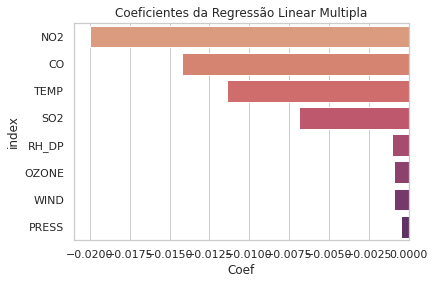

In [308]:
linear_regressor = sklearn.linear_model.LinearRegression(copy_X=True, normalize=False)
linear_regressor.fit(df_fs[attrs], df_fs[erro_col])

df_coef = pd.DataFrame(linear_regressor.coef_[0], index=attrs, columns=['Coef']).sort_values(by='Coef', ascending=True).reset_index()
print(df_coef)

sns.barplot(data=df_coef, x='Coef', y='index', orient='h', palette='flare').set_title('Coeficientes da Regressão Linear Multipla')

# Análise dos Métodos

###Copiando Dataset para evitar overwrite

In [207]:
method_related_cols = ['Method', 'Nº Attributes to select']
methods = ['VarianceTreshold', 'SelectKBest_f_regression', 'SelectKBest_mutual_info_regression', 'SequentialFeatureSelector', 'RFE']
df_mtd = deepcopy(df_final[method_related_cols + erro_col])
df_mtd['RMSE norm'] = (df_mtd['RMSE'] - df_mtd['RMSE'].min())/(df_mtd['RMSE'].max()-df_mtd['RMSE'].min())
df_mtd = df_mtd.rename(columns={'Nº Attributes to select':'n'})

df_mtd_partial = df_mtd[df_mtd['Method'].apply(lambda x: x in methods) ]

df_mtd

,Method,n,RMSE,RMSE norm
0,VarianceTreshold,3,0.374676,1.000000
1,SelectKBest_f_regression,3,0.339690,0.338877
2,SelectKBest_mutual_info_regression,3,0.329618,0.148540
3,SequentialFeatureSelector,3,0.337787,0.302909
4,RFE,3,0.327977,0.117535
5,VarianceTreshold,4,0.332085,0.195160
6,SelectKBest_f_regression,4,0.329488,0.146092
7,SelectKBest_mutual_info_regression,4,0.336935,0.286809
8,SequentialFeatureSelector,4,0.332289,0.199016
9,RFE,4,0.329267,0.141921


### Metodos x RMSE

##### Comparação de Métodos para cada n (Tá aqui just in case. Não acho que agrege muito)

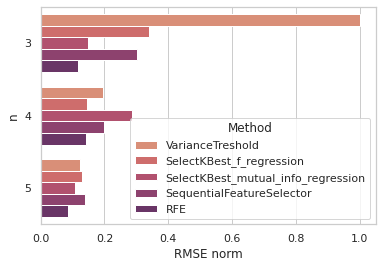

In [311]:
sns.barplot(data=df_mtd_partial, y="n", x="RMSE norm", orient='h',hue="Method", ci='sd', palette='flare')


##### Leva em conta n nos gráficos

Achei que ficou melhor plotando em barras Deixei aqui para voces verem a possibilidade de plotar em linha tbm
- Varias linhas juntas ficou muito confuso

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


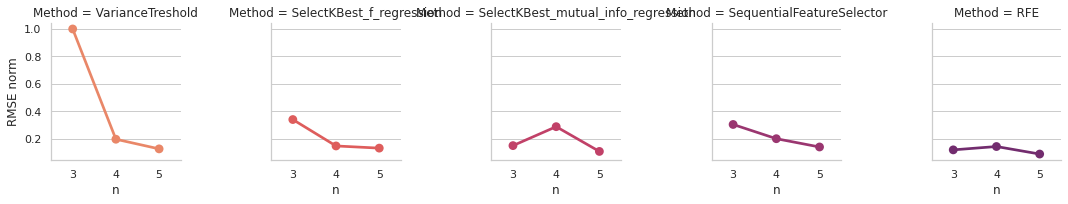

In [309]:
g = sns.FacetGrid(df_mtd_partial, col="Method", hue='Method', palette='flare')
g.map(sns.pointplot, "n", "RMSE norm", ci=0.95, n_boot=2)

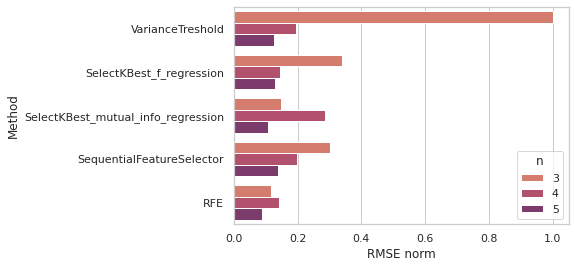

In [312]:
sns.barplot(data=df_mtd_partial, y="Method", x="RMSE norm", hue="n", ci='sd', palette='flare', orient='h')

##### Usando n como estimativa de Erro

(0.31, 0.38435374673273365)

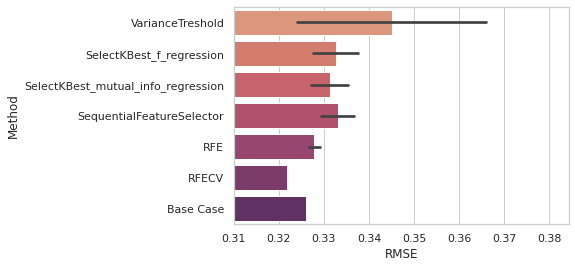

In [305]:
sns.barplot(data=df_mtd, y="Method", x="RMSE", ci='sd', palette='flare', orient='h').set_xlim(0.31)

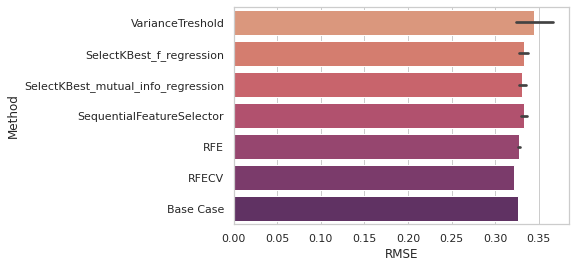

In [306]:
sns.barplot(data=df_mtd, y="Method", x="RMSE", ci='sd', palette='flare', orient='h')

# Eficiência dos Metodos Comparação com o tempo (WIP)